In [96]:
import math
import glob
import pyarrow

import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tqdm import tqdm
from scipy.signal import find_peaks
import scipy.signal as signal
from mpl_toolkits import mplot3d
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use("dark_background")

import warnings
warnings.filterwarnings('ignore')

### Data for W3

In [ ]:
base_run = ['X_105191.pqt', 'X_114619.pqt', 'X_171481.pqt', 'X_172043.pqt', 'X_17782.pqt', 'X_190697.pqt', 'X_190751.pqt', 'X_191595.pqt', 'X_220304.pqt', 'X_226626.pqt', 'X_302390.pqt', 'X_306034.pqt', 'X_374570.pqt', 'X_384280.pqt', 'X_446785.pqt', 'X_479160.pqt', 'X_509896.pqt', 'X_528715.pqt', 'X_539065.pqt', 'X_540675.pqt', 'X_548610.pqt', 'X_558583.pqt', 'X_559041.pqt', 'X_581906.pqt', 'X_612639.pqt', 'X_617465.pqt', 'X_705788.pqt', 'X_727727.pqt', 'X_763178.pqt', 'X_777652.pqt', 'X_780881.pqt', 'X_836967.pqt', 'X_839630.pqt', 'X_840215.pqt', 'X_898052.pqt', 'X_900785.pqt', 'X_902161.pqt', 'X_902493.pqt', 'X_909056.pqt', 'X_94386.pqt', 'X_949535.pqt','X_14035.pqt', 'X_227901.pqt', 'X_271585.pqt', 'X_297647.pqt', 'X_321996.pqt', 'X_335791.pqt', 'X_337438.pqt', 'X_357745.pqt', 'X_365676.pqt', 'X_408632.pqt', 'X_41533.pqt', 'X_422874.pqt', 'X_458707.pqt', 'X_494651.pqt', 'X_522573.pqt', 'X_527137.pqt', 'X_714425.pqt', 'X_72695.pqt', 'X_807308.pqt', 'X_808435.pqt', 'X_832612.pqt', 'X_888741.pqt', 'X_978157.pqt', 'X_994105.pqt']
base_dat = [19995, 13132,  3272, 43628, 36436,  8152,  5287,  6861, 44643, 28121, 32071, 24471,11819, 41242,  3218, 18133,  5822, 94569, 19891, 17423, 41133,  5449,  9888,  8500,14848, 42115, 14178, 14646, 11948, 881, 18136, 41944, 35328, 12332,  5411,  7708,69998,  2708, 20823,  3276, 53211,4048, 33199, 24595, 21544, 18222, 13629, 65288, 39009, 7637, 20581, 35728, 4108, 14493, 32409, 23205, 19304, 9824, 93154, 3490, 4070, 14229, 28009, 36822, 17758]

grass_run = ['X_207427.csv', 'X_214370.csv', 'X_220709.csv', 'X_230931.csv', 'X_231724.csv', 'X_248516.csv', 'X_249686.csv', 'X_252258.csv', 'X_263573.csv', 'X_31510.csv', 'X_350884.csv', 'X_424316.csv', 'X_49094.csv', 'X_512397.csv', 'X_550546.csv', 'X_594223.csv', 'X_674555.csv', 'X_67519.csv', 'X_69357.csv', 'X_699624.csv', 'X_73057.csv', 'X_739518.csv', 'X_753334.csv', 'X_778668.csv', 'X_800047.csv', 'X_803205.csv', 'X_824630.csv', 'X_829648.csv', 'X_838253.csv', 'X_839487.csv', 'X_859561.csv', 'X_888245.csv', 'X_955844.csv', 'X_95873.csv', 'X_99693.csv']
grass_dat = [53791, 15209,  2425,  3700, 12720, 10565,  2568,  6329, 62916,26767,  8641, 15650, 15459,  8598, 27717, 25312, 66595, 62286,2373,  5644, 76007, 19441,  2866, 13529,  2940, 19177, 28866,11997, 56875, 22492,   611, 18273, 11689,  7036, 42424]

shark_run = ['X_12569.csv', 'X_12891.csv', 'X_21664.csv', 'X_27526.csv', 'X_30276.csv', 'X_33809.csv', 'X_34842.csv', 'X_37247.csv', 'X_4179.csv', 'X_44012.csv', 'X_45864.csv', 'X_54829.csv', 'X_55860.csv', 'X_56441.csv', 'X_64430.csv', 'X_64695.csv', 'X_74179.csv', 'X_74430.csv', 'X_74774.csv', 'X_75824.csv', 'X_8545.csv', 'X_87926.csv', 'X_88530.csv', 'X_88858.csv', 'X_89900.csv', 'X_90855.csv', 'X_92794.csv', 'X_95085.csv']
shark_dat = [3698, 36173, 118539, 80252, 96862, 20866, 23271, 290368, 68681, 37775, 20684, 35137, 32144, 163715, 4796, 52655, 193719, 62118, 14272, 108211, 254584, 208747, 52942, 182880, 138396, 225770, 14703, 121724]

print(f"base data size: {len(base_dat)}, grass data size: {len(grass_dat)}, shark data size: {len(shark_dat)}")

## Functions

In [20]:
def extract(df, tpe = "csv"):
    return pl.read_csv(df) if tpe == "csv" else pl.read_parquet(f"{df}")

In [21]:
def plot_df(df_path, tpe = "csv", multid = False, name = None):
    df = extract(df_path, tpe)
    search = "fox" if "fox" in list(df.columns) else "type"
    
    if multid:
        q = (df.groupby("frame").agg(
                        [
                                (pl.col(search) == 1).sum().alias("fox"),
                                (pl.col(search) == 0).sum().alias("rabbit"),
                                ((pl.col(search) == 2) & (pl.col("image_index") == 0)).sum().alias("grass")
                        ]).sort("frame"))
        gl = q["grass"].to_list() 
        
    else:
        q = (df.groupby("frame").agg(
                        [
                                (pl.col(search) == 1).sum().alias("fox"),
                                (pl.col(search) == 0).sum().alias("rabbit")
                        ]).sort("frame"))
        
    fl = q["fox"].to_list()
    rl = q["rabbit"].to_list()
    ln = len(rl)
    c = list(range(ln))    
    
    
    #oscillator
    fig, ax = plt.subplots(figsize=(6,6))
    fig.suptitle(df_path)

    ax.plot(fl,c="r")
    ax.plot(rl,c="b")
    if multid: ax.plot(gl,c="g")
    legend = ["foxes","rabbits","grass"] if multid else ["foxes","rabbits"]
    ax.legend(legend)
    ax.set_ylabel("Number of Individuals")
    ax.set_xlabel("Frames")
    ax.set_yscale("log")
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    plt.savefig(f"plots/oscillation_{name}.png",dpi=300, transparent = True)

    
    
    

    #Non 3d cycle
    fig, ax = plt.subplots(figsize=(6,6))
    fig.suptitle(df_path)
    
    pcm = ax.scatter(fl,rl,s=2,c=c,cmap="rainbow")
    ax.set_ylabel("Rabbits")
    ax.set_xlabel("Foxes")
    fig.colorbar(pcm, ax=ax,label="Frames", orientation='vertical',format=ticker.EngFormatter())
    plt.savefig(f"plots/rotary_{name}.png",dpi=300, transparent = True)
    
    
    #3d cycle
    if multid:
        fig = plt.figure(figsize=(6,6))
        ax = plt.axes(projection='3d')
        fig.suptitle(df_path)
        
        ax.set_ylabel("Rabbits")
        ax.set_xlabel("Foxes")
        ax.set_zlabel("Grass")
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        pcm = ax.scatter3D(fl,rl,gl,s=2,c=c,cmap="rainbow")
        fig.colorbar(pcm, ax=ax,label="Frames", orientation='horizontal',format=ticker.EngFormatter())

        for angle in tqdm(range(0, 360,30)):
            ax.view_init(30, angle)
            plt.savefig(f"plots/3d_rotary_{name}_{angle}.png",dpi=300, transparent = True)
    

    

In [22]:
def draw_boxp(dat,runs,size=None,name=None):
    middle = len(dat)//2
    median = np.sort(dat)[middle]
    
    vals = [np.nanmean(dat),median,min(dat),max(dat)]
    
    f, ax = plt.subplots(figsize=(4, 6))
    f.suptitle("Duration of Simulations")
    
    
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    ax.annotate(f"Max: {vals[3]}",(-0.48,vals[3]+1500), color = "y")
    ax.annotate(f"Min: {vals[2]}",(-0.48,vals[2]+1500),color = "y")
    ax.annotate(f"Mean: {vals[0]:.2f}",(-0.48,vals[0]+1500),color = "r")
    ax.annotate(f"Median: {vals[1]:.0f}",(-0.48,vals[1]+1500),color = "r")
    
    df = pd.DataFrame(list(zip([0]*len(dat),dat)),columns =['group','val'])
    df2 = df.assign(hue=1)
    sns.boxplot(data=df2,x="group" ,y="val",hue="hue", hue_order=[1,0])
    g = sns.violinplot(data=df2,x="group"  ,y="val",hue="hue",inner="stick",cut=0, split=True, hue_order=[0,1])
    ax.set_ylabel("Frames")
    ax.set_xlabel("Simulations")
    
    

    ax.axhline(vals[0],c = "r")
    ax.axhline(vals[1],c = "r")

    ax.axhline(vals[2],c = "y")
    ax.axhline(vals[3],c = "y")
    if size:
        ax.set_ylim(0,size)
    
    g.legend_.remove()
    
    plt.tight_layout()
    plt.savefig(f"plots/stability_{name}.png",dpi=300, transparent = True)
    s = list(dat).index(vals[1])
    m = list(dat).index(vals[3])
    mn = list(dat).index(vals[2])
    print(f"Median:{runs[s]},Max:{runs[m]},Min:{runs[mn]}")

In [116]:
def score(dat,tpe = "csv", plot=True, name = None):
    df = extract(dat, tpe = tpe)
    q = df.groupby("frame").agg(
                [
                        (pl.col("type") == 1).sum().alias("fox"),
                        (pl.col("type") == 0).sum().alias("rabbit")

                ]).sort("frame")
    q = q.to_pandas()
    
    
    peak_idxs_fox = find_peaks(q["fox"], width=100)[0]
    peak_vals_fox = q["fox"].array[peak_idxs_fox]
    val_idxs_fox = np.setdiff1d(find_peaks(-q["fox"], width=100)[0], peak_idxs_fox)
    val_vals_fox = q["fox"].array[val_idxs_fox]

    peak_std_fox = peak_vals_fox.std()/(peak_vals_fox.mean()-val_vals_fox.mean())
    val_std_fox = val_vals_fox.std()/(peak_vals_fox.mean()-val_vals_fox.mean())

    peak_idxs_rab = find_peaks(q["rabbit"], width=100)[0]
    peak_vals_rab = q["rabbit"].array[peak_idxs_rab]
    val_idxs_rab = np.setdiff1d(find_peaks(-q["rabbit"], width=100)[0], peak_idxs_rab)
    val_vals_rab = q["rabbit"].array[val_idxs_rab]

    peak_std_rab = peak_vals_rab.std()/(peak_vals_rab.mean()-val_vals_rab.mean())
    val_std_rab = val_vals_rab.std()/(peak_vals_rab.mean()-val_vals_rab.mean())

    
    
    
    score = max(peak_std_rab, val_std_rab) + max(peak_std_fox, val_std_fox)
    score_avg = np.mean([peak_std_rab, val_std_rab]) + np.mean([peak_std_fox, val_std_fox])
    
    
    pred_peakind = signal.find_peaks(q[['fox']].values.flatten(),width=150,distance=700,height=13)
    prey_peakind = signal.find_peaks(q[['rabbit']].values.flatten(),width=150,distance=700,height=13)
    
    v1 = round(np.diff(prey_peakind[0]).mean(),2)
    v2 = round(np.diff(pred_peakind[0]).mean(),2)
    
    
    
    num_cyc_fox = np.floor(np.mean([len(peak_idxs_fox),len(val_idxs_fox)]))
    num_cyc_rab = np.floor(np.mean([len(peak_idxs_rab),len(val_idxs_rab)]))
    
    
    if plot:
            fig, ax = plt.subplots(figsize=(6,6))
        
            ax.plot(q["fox"].to_list(), c = "r", label="foxes")
            ax.plot(peak_idxs_fox, q["fox"].array[peak_idxs_fox])
            ax.plot(val_idxs_fox, q["fox"].array[val_idxs_fox])
            
            ax.plot(q["rabbit"].to_list(), c = "b", label = "rabbits")
            ax.plot(peak_idxs_rab, q["rabbit"].array[peak_idxs_rab])
            ax.plot(val_idxs_rab, q["rabbit"].array[val_idxs_rab])
        

            for i,el in enumerate(pred_peakind[0]):
                ax.plot(el,q["fox"].values[el],'wo')
            for i,el in enumerate(prey_peakind[0]):
                ax.plot(el,q["rabbit"].values[el],'wo')


            ax.legend()
            ax.set_ylabel("Number of Individuals")
            ax.set_xlabel("Frames")
            ax.set_yscale("log")
            ax.xaxis.set_major_formatter(ticker.EngFormatter())
            plt.savefig(f"plots/stability_{name}.png",dpi=300, transparent = True)

   
    #print(f"score: {score}, score_avg: {score_avg}") 
    return {'score':score,
            'score_avg':score_avg,
            'pred_avg_len':v2,
            'prey_avg_len':v1,
            'cycle-fitness':round(max(v1,v2)/min(v1,v2),2)-1,
            'number_pred_cycles':num_cyc_fox,
            'number_prey_cycles': num_cyc_rab}

In [105]:
def gene_convergence(dat,tpe = "csv", name = None, plot = True):
    df = extract(dat, tpe)
    df = df.to_pandas()
    
    pdf = df[(df["type"]==1)]    
    pdf.loc[:,("mass","vision")] = pdf.loc[:,("mass","vision")]/1000
    pdf.to_csv(f"{dat}_transformed.csv")

    df = extract(f"{dat}_transformed.csv", "csv")
    q = (df.groupby("frame").agg(
                        [
                                (pl.col("mass")).mean().alias("mass_avg"),
                                (pl.col("mass")).std().alias("mass_std"),
                                (pl.col("mass")).max().alias("mass_max"),
                                (pl.col("mass")).min().alias("mass_min"),
                                (pl.col("vision")).mean().alias("vision_avg"),
                                (pl.col("vision")).std().alias("vision_std"),
                                (pl.col("vision")).max().alias("vision_max"),
                                (pl.col("vision")).min().alias("vision_min")
                        ]).sort("frame"))
    
    mm = q["mass_avg"].to_list()
    mv = q["vision_avg"].to_list()
    
    
    
    if plot:
        rnge = list(range(len(mm)))
    
        mmax = q["mass_max"].to_list()
        mmin = q["mass_min"].to_list()

        vmax = q["vision_max"].to_list()
        vmin = q["vision_min"].to_list()

        vstd = q["vision_std"].to_list()
        mstd = q["mass_std"].to_list()
        
        fig, ax = plt.subplots(figsize=(10, 6))

        ax.plot(mm, c="y",label="mean mass")
        ax.fill_between(rnge,[x1 - x2 for (x1, x2) in zip(mm, mstd)],
                        [x1 + x2 for (x1, x2) in zip(mm, mstd)],
                        alpha = 0.2,
                        facecolor = "lightcoral")
        ax.fill_between(rnge,mmin,mmax,color="y",alpha = 0.2)

        ax.plot(mv, c="c", label = "mean vision")
        ax.fill_between(rnge,[x1 - x2 for (x1, x2) in zip(mv, vstd)],
                        [x1 + x2 for (x1, x2) in zip(mv, vstd)],
                        alpha = 0.2,
                        facecolor = "cornflowerblue")
        ax.fill_between(rnge, vmin,vmax, color="c", alpha = 0.2)


        ax.legend()
        ax.set_ylabel("Value of Genes")
        ax.set_xlabel("Frames")
        ax.xaxis.set_major_formatter(ticker.EngFormatter())
        plt.savefig(f"plots/gene_convergance_{name}.png",dpi=300, transparent = True)
    return mm, mv

In [ ]:
def number_of_cycles(q):
        width = 150
        query = "fox"
        peak_idxs_fox = find_peaks(q[query], width=width)[0]
        val_idxs_fox = np.setdiff1d(find_peaks(-q[query], width=width)[0], peak_idxs_fox)
        num_cyc_fox = np.floor(np.mean([len(peak_idxs_fox),len(val_idxs_fox)]))

        peak_idxs_rab = find_peaks(q["rabbit"], width=width)[0]
        val_idxs_rab = np.setdiff1d(find_peaks(-q["rabbit"], width=width)[0], peak_idxs_rab)
        num_cyc_rab = np.floor(np.mean([len(peak_idxs_rab),len(val_idxs_rab)]))

        return num_cyc_fox, num_cyc_rab

## Plot Data

Median:X_479160.pqt,Max:X_528715.pqt,Min:X_777652.pqt
Median:X_214370.csv,Max:X_73057.csv,Min:X_859561.csv
Median:X_4179.csv,Max:X_37247.csv,Min:X_12569.csv


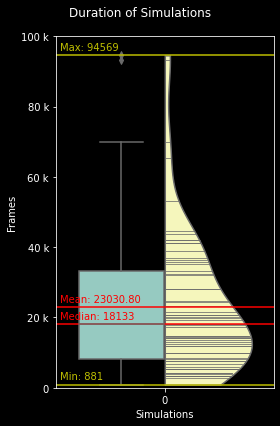

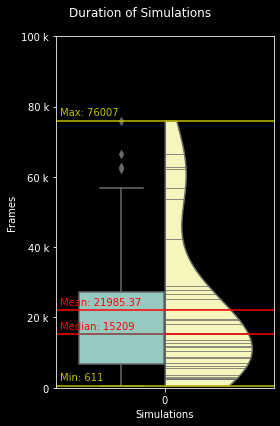

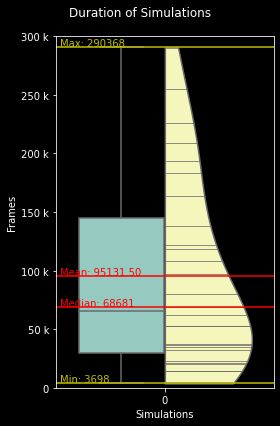

In [34]:
draw_boxp(shark_dat,shark_run,300000,"shark")

In [111]:
dfs = glob.glob("X_sexual*.csv")

In [97]:
mms = []
mvs = []
for df in tqdm(dfs):
    dat = gene_convergence(df, tpe = "csv", name = df, plot = False)
    mms.append(dat[0])
    mvs.append(dat[1])

100%|██████████████████████████████████████████████████████████████████████████████████| 87/87 [03:59<00:00,  2.75s/it]


In [112]:
def diff_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)


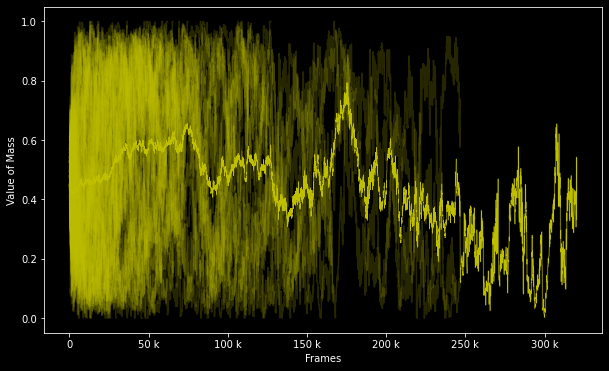

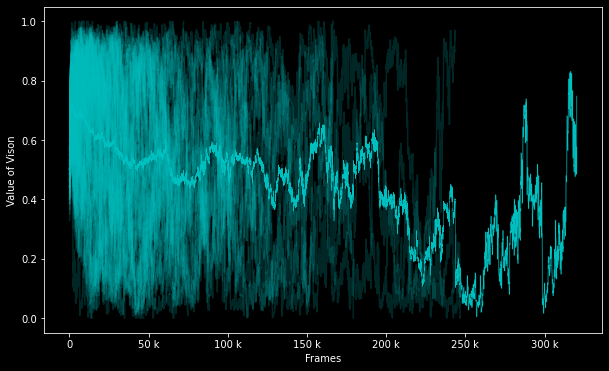

In [115]:
fig, ax = plt.subplots(figsize=(10, 6))
for mm in mms:
    ax.plot(mm,c="y",alpha=0.2)
ax.plot(diff_mean(mms)[0],c="y",linewidth =0.5 )
ax.set_ylabel("Value of Mass")
ax.set_xlabel("Frames")
ax.xaxis.set_major_formatter(ticker.EngFormatter())
plt.savefig(f"plots/mass_total.png",dpi=300, transparent = True)
    
    
fig, ax = plt.subplots(figsize=(10, 6))
for mv in mvs:
    ax.plot(mv,c="c",alpha=0.2)
ax.plot(diff_mean(mvs)[0],c="c",linewidth =0.5 )
ax.set_ylabel("Value of Vison")
ax.set_xlabel("Frames")
ax.xaxis.set_major_formatter(ticker.EngFormatter())
plt.savefig(f"plots/vision_total.png",dpi=300, transparent = True)

In [99]:
lens = []
for df in tqdm(dfs):
    dat = extract(df)
    lens.append(dat["frame"][-1])

100%|██████████████████████████████████████████████████████████████████████████████████| 87/87 [00:40<00:00,  2.16it/s]


Median:X_sexual_296252.csv,Max:X_sexual_283176.csv,Min:X_sexual_639374.csv


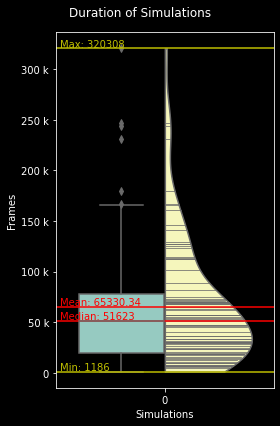

In [100]:
draw_boxp(lens,dfs,name="sexual")

In [101]:
scores = list(map(list,scores))
scores = list(list(zip(*scores))[0])

In [102]:
print(f"average: {np.average(scores)}, max: {np.max(scores)}, min: {np.min(scores)}")

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U5'), dtype('<U5')) -> None

{'score': 1.3924203206635495,
 'score_avg': 1.160896378936798,
 'pred_avg_len': 1738.9,
 'prey_avg_len': 1750.68,
 'cycle-fitness': 0.010000000000000009,
 'number_pred_cycles': 92.0,
 'number_prey_cycles': 80.0}

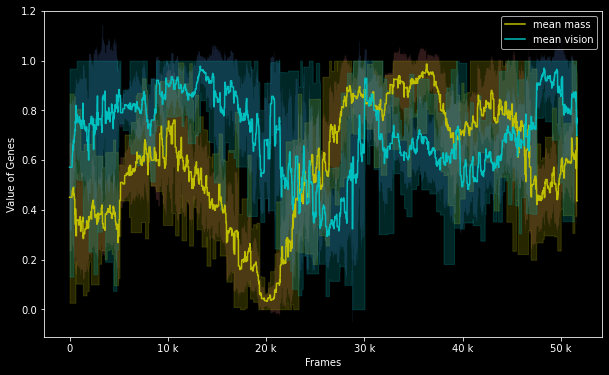

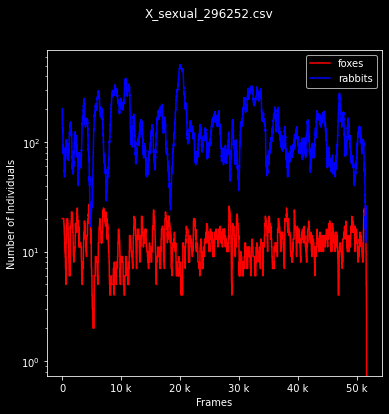

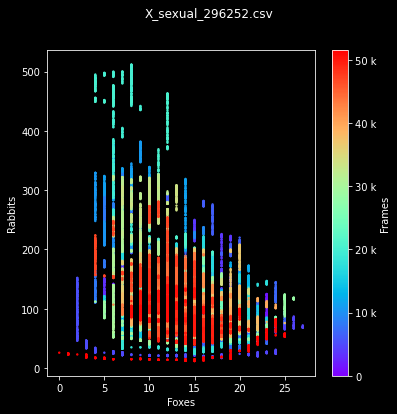

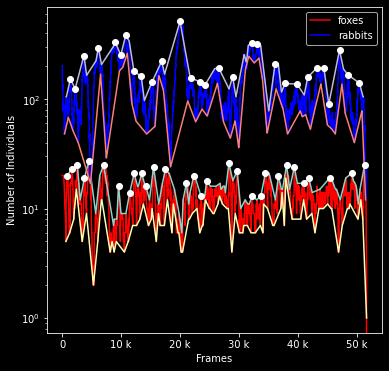

In [117]:
gene_convergence("X_sexual_296252.csv", tpe = "csv", name = "X_sexual_296252.csv", plot = True)
plot_df("X_sexual_296252.csv",tpe = "csv", name="X_sexual_296252.csv")
score("X_sexual_296252.csv", name ="X_sexual_296252.csv")